Unificando tablas...
Dataset Maestro creado con 343 registros.


C:\Users\Miguel\AppData\Local\Temp\ipykernel_29320\2889120640.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cantidad, x='cantidad', y=top_cantidad.index, ax=axes[0], palette='viridis')
C:\Users\Miguel\AppData\Local\Temp\ipykernel_29320\2889120640.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ingresos, x='importe', y=top_ingresos.index, ax=axes[1], palette='magma')


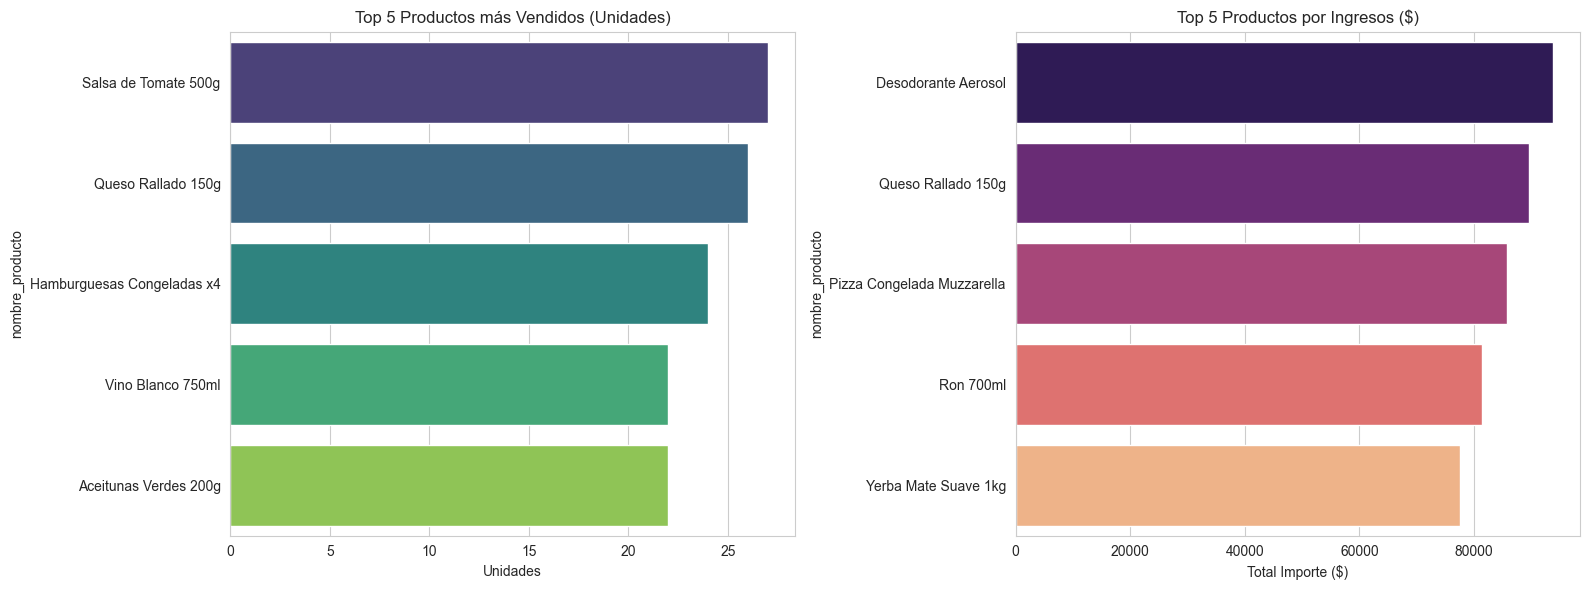


 Analizando Tendencias Temporales...


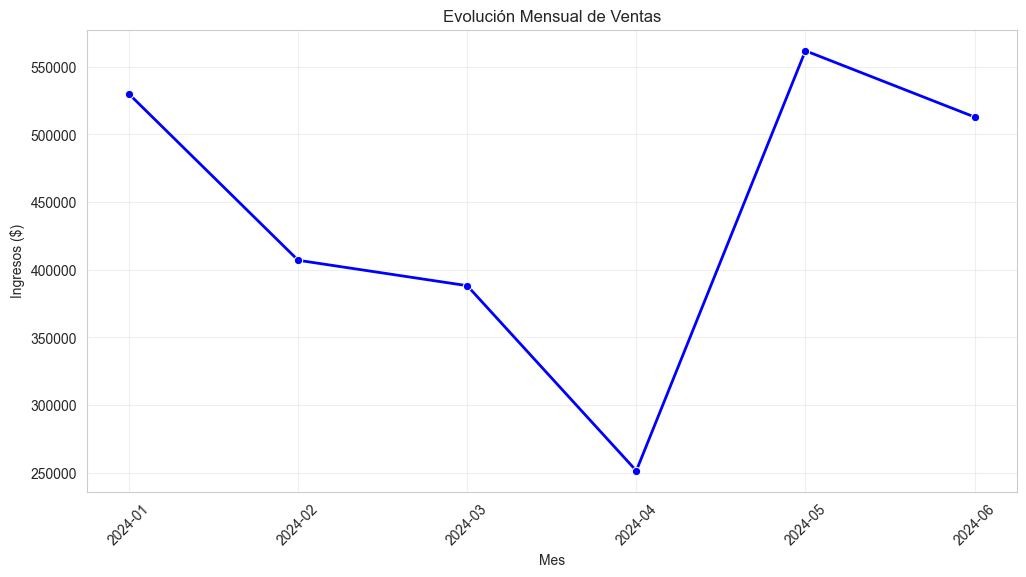

C:\Users\Miguel\AppData\Local\Temp\ipykernel_29320\2889120640.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clientes.values, y=top_clientes.index, palette='coolwarm')


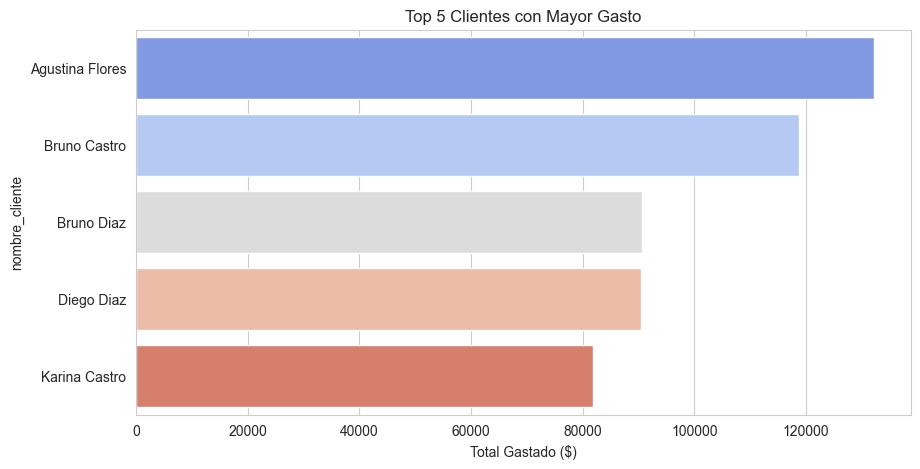

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACIÓN INICIAL ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def cargar_y_procesar_datos():
    """
    Carga los datos y realiza las fusiones (merges) manejando colisiones de nombres.
    """    
    # 1. CARGA
    try:
        df_cli = pd.read_excel('clientes.xlsx')
        df_det = pd.read_excel('detalle_ventas.xlsx')
        df_prod = pd.read_excel('productos.xlsx')
        df_ven = pd.read_excel('ventas.xlsx')
    except FileNotFoundError as e:
        print(f"Error: No se encontró el archivo. {e}")
        return None

    # 2. CONVERSIÓN DE FECHAS
    # Convertimos la columna fecha de texto a objeto datetime
    df_ven['fecha'] = pd.to_datetime(df_ven['fecha'])

    # 3. FUSIÓN DE DATOS (DATA MERGING) - CORREGIDO
    print("Unificando tablas...")

    # Paso A: Unir Detalle con Ventas (Relación: id_venta)
    # Usamos 'inner' para mantener solo registros consistentes
    df_master = pd.merge(df_det, df_ven, on='id_venta', how='inner')

    # Paso B: Unir con Productos (Relación: id_producto)
    # Usamos suffixes=('', '_dup') para que la columna original se mantenga limpia.
    df_master = pd.merge(df_master, df_prod, on='id_producto', how='left', suffixes=('', '_prod_dup'))

    # Paso C: Unir con Clientes (Relación: id_cliente)
    # 'nombre_cliente' y 'email' existen en ventas y clientes. Gestionamos duplicados.
    df_master = pd.merge(df_master, df_cli, on='id_cliente', how='left', suffixes=('', '_cli_dup'))

    print(f"Dataset Maestro creado con {df_master.shape[0]} registros.")
    return df_master

def analizar_top_productos(df):
    """
    Tarea 3: Genera el Top 5 de productos por Cantidad y por Dinero generado.
    """
    # Agrupamos por el nombre del producto
    metricas_prod = df.groupby('nombre_producto').agg({
        'cantidad': 'sum',
        'importe': 'sum'
    }).sort_values('cantidad', ascending=False)

    top_cantidad = metricas_prod.head(5)
    top_ingresos = metricas_prod.sort_values('importe', ascending=False).head(5)

    # Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico Cantidad
    sns.barplot(data=top_cantidad, x='cantidad', y=top_cantidad.index, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 5 Productos más Vendidos (Unidades)')
    axes[0].set_xlabel('Unidades')
    
    # Gráfico Ingresos
    sns.barplot(data=top_ingresos, x='importe', y=top_ingresos.index, ax=axes[1], palette='magma')
    axes[1].set_title('Top 5 Productos por Ingresos ($)')
    axes[1].set_xlabel('Total Importe ($)')
    
    plt.tight_layout()
    plt.show()

def analizar_ventas_tiempo(df):
    """
    Tarea 4: Evolución mensual de las ventas.
    """
    print("\n Analizando Tendencias Temporales...")
    
    # Creamos una columna Periodo (Año-Mes) para agrupar
    df['periodo'] = df['fecha'].dt.to_period('M')
    
    # Sumamos importes por periodo
    ventas_mes = df.groupby('periodo')['importe'].sum()
    
    # Convertimos el índice a string para graficar
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=ventas_mes.index.astype(str), y=ventas_mes.values, marker='o', color='blue', linewidth=2)
    
    plt.title('Evolución Mensual de Ventas')
    plt.ylabel('Ingresos ($)')
    plt.xlabel('Mes')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

def analizar_top_clientes(df):
    """
    Tarea 5: Top 5 mejores clientes.
    """
    # Agrupamos por cliente
    top_clientes = df.groupby('nombre_cliente')['importe'].sum().sort_values(ascending=False).head(5)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_clientes.values, y=top_clientes.index, palette='coolwarm')
    plt.title('Top 5 Clientes con Mayor Gasto')
    plt.xlabel('Total Gastado ($)')
    plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    df_maestro = cargar_y_procesar_datos()
    
    if df_maestro is not None:
        # Validamos que las columnas críticas existan antes de continuar
        columnas_necesarias = ['nombre_producto', 'importe', 'cantidad', 'fecha', 'nombre_cliente']
        if all(col in df_maestro.columns for col in columnas_necesarias):
            analizar_top_productos(df_maestro)
            analizar_ventas_tiempo(df_maestro)
            analizar_top_clientes(df_maestro)
        else:
            print("Error crítico: Faltan columnas en el DataFrame maestro después de la fusión.")
            print("Columnas encontradas:", df_maestro.columns.tolist())